# Lesson 10 - Sentiment Analysis
## Author - Salinee Kingbaisomboon
### UW NetID: 1950831

This assignment requires that you build a sentiment analysis classifier for a series of tweets.
The data consists of a file "twitter_data.csv". The file contains 16,000 tweets with their respective score. The attributes are the sentences, and the score is either 4 (for positive) or 0 (for negative).

Assignment Instructions
1. Complete all questions below.
2. Comment on the applicability of the model on future tweets.  

In [5]:
#Imports
import string
import re
# import nltk # Get No module named '_sqlite3' error on the Virtual Lab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
#from nltk.corpus import stopwords # Get No module named '_sqlite3' error on the Virtual Lab
#from nltk.stem.wordnet import WordNetLemmatizer # Get No module named '_sqlite3' error on the Virtual Lab
from scipy.sparse import coo_matrix

import warnings

warnings.filterwarnings("ignore") # To suppress warning

%matplotlib inline

# Declare Functions used in this assignment

In [2]:
# Create a function to clean the text
def preprocess(text, list_of_steps):
    
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        elif step == 'lowercase':
            text = text.lower()
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
# Get No module named '_sqlite3' error on the Virtual Lab
#         elif step == 'remove_stopwords':
#             stops = stopwords.words('english')
#             word_list = text.split(' ')
#             text_words = [word for word in word_list if word not in stops]
#             text = ' '.join(text_words)
#         elif step == 'stem_words':
#             lmtzr = WordNetLemmatizer()
#             word_list = text.split(' ')
#             stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
#             text = ' '.join(stemmed_words)
    return text

In [3]:
# Create a function to generate the word cloud data frame
def generate_word_cloud(data, cutoff, sentiment):
    # Filter the data sorce based on the sentiment (0 = positive, 1 = negative)
    tweet_data = data[data.sentiment_label == sentiment].values.tolist()
    clean_texts = data[data.sentiment_label == sentiment].clean_tweet
    
    # Create a document storage matrix
    docs = {}
    for ix, row in enumerate(clean_texts):
        docs[ix] = row.split(' ')
        
    # We want to keep track of how many unique words there are:
    num_nonzero = 0
    vocab = set()
    for word_list in docs.values():
        unique_terms = set(word_list)    # all unique terms of this tweet
        vocab.update(unique_terms)       # set union: add unique terms of this tweet
        num_nonzero += len(unique_terms) # add count of unique terms in this tweet

    doc_key_list = list(docs.keys())
    
    # Need to convert everything to a numpy array: (for quicker calculation)
    doc_key_list = np.array(doc_key_list)
    vocab = np.array(list(vocab))
    
    # We should keep track of how the vocab/term indices map to the matrix so that we can look them up later.
    vocab_sorter = np.argsort(vocab)
    
    # Initialize our sparse matrix:
    num_docs = len(doc_key_list)
    vocab_size = len(vocab)
    # A COO matrix is just a tuple of data, row indices, and column indices. Everything else is assumed to be zero.
    data = np.empty(num_nonzero, dtype=np.intc)     # all non-zero
    rows = np.empty(num_nonzero, dtype=np.intc)     # row index
    cols = np.empty(num_nonzero, dtype=np.intc)     # column index
    
    ix = 0
    print('Computing full term-document matrix (sparse), please wait!')
    for doc_key, terms in docs.items():
        # Find indices where elements should be inserted to maintain order
        term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]

        # count the unique terms of the document and get their vocabulary indices
        uniq_indices, counts = np.unique(term_indices, return_counts=True)
        n_vals = len(uniq_indices)  # = number of unique terms
        ix_end = ix + n_vals # Add count to index

        data[ix:ix_end] = counts                  # save the counts (term frequencies)
        cols[ix:ix_end] = uniq_indices            # save the column index: index in 
        doc_ix = np.where(doc_key_list == doc_key)   # get the document index for the document name
        rows[ix:ix_end] = np.repeat(doc_ix, n_vals)  # save it as repeated value

        ix = ix_end  # resume with next document -> will add future data on the end.
    
    # Create the sparse matrix!
    doc_term_mat = coo_matrix((data, (rows, cols)), shape=(num_docs, vocab_size), dtype=np.intc)
    
    # Trimming the Doc-term matrix
    word_counts = doc_term_mat.sum(axis=0)
    
    # Look at how many words are above a specific cutoff
    word_count_list = word_counts.tolist()[0]
    
    # Find which column indices are above cutoff
    col_cutoff_ix = [ix for ix, count in enumerate(word_count_list) if count > cutoff]
    
    # Get the trimmed vocabulary
    vocab_trimmed = np.array([vocab[x] for x in col_cutoff_ix])

    # Re-do the vocab-sorter
    vocab_sorter_trimmed = np.argsort(vocab_trimmed)
    
    # Trim the document-term matrix
    doc_term_mat_trimmed = doc_term_mat.tocsc()[:,col_cutoff_ix]
        
    # Plot trimmed vocabulary frequency
    trimmed_word_counts = doc_term_mat_trimmed.sum(axis=0)
    trimmed_word_list = trimmed_word_counts.tolist()[0]
    hist_breaks = np.arange(0, 500, 5)
    plt.hist(trimmed_word_list, bins = hist_breaks)
    plt.title('Histogram of trimmed word counts < 500')
    plt.show()
    
    # Placeholder for return data frame
    data_df = pd.DataFrame()
  
    # Find which tweets contain word:
    appended_word = []
    appended_word_count = []

    # Look for how may indident this trimmed vocabulary appear on the tweet
    for x in  vocab_sorter_trimmed:
        doc_ix_with_word = []
        word_of_interest = vocab_trimmed[vocab_sorter_trimmed[x]] # get the word
        appended_word.append(word_of_interest)
        vocab_interesting_ix = list(vocab).index(word_of_interest) # get index the word from vocabulary list
        for ix, row in enumerate(tweet_data): # look into the tweet data
            if word_of_interest in row[1]: # if found match
                doc_ix_with_word.append(ix) # add indident index
        appended_word_count.append(len(doc_ix_with_word)) # count the total index to get the number of occurance
    
    data_df['word'] = appended_word
    data_df['word_count'] = appended_word_count 
    
    print('Done!')
    
    return data_df

# Process Data

In [6]:
#Read files
url = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/twitter_data.csv"
df = pd.read_csv(url, sep=",")
df.columns = ["sentiment_label","tweet_text"]

# But sentiment is either '4' or '0'. We'll change that to '1' or '0' to indicate positive or negative sentiment.
df.sentiment_label=df.sentiment_label.replace(4,1)
    
# Clean tweets
steps = ['lowercase', 'remove_punctuation', 'remove_numbers', 'strip_whitespace']

df['clean_tweet'] = df['tweet_text'].map(lambda s: preprocess(s, steps))

# Check the Data Frame for first five rows
print(df.head())

# Check the Data Frame's statistics summary
df.describe()

   sentiment_label                                         tweet_text  \
0                1  @elephantbird Hey dear, Happy Friday to You  A...   
1                1  Ughhh layin downnnn    Waiting for zeina to co...   
2                0  @greeniebach I reckon he'll play, even if he's...   
3                0              @vaLewee I know!  Saw it on the news!   
4                0  very sad that http://www.fabchannel.com/ has c...   

                                         clean_tweet  
0  elephantbird hey dear happy friday to you alre...  
1  ughhh layin downnnn waiting for zeina to cook ...  
2  greeniebach i reckon hell play even if hes not...  
3                  valewee i know saw it on the news  
4  very sad that httpwwwfabchannelcom has closed ...  


,sentiment_label
count,160000.000000
mean,0.500000
std,0.500002
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


Q1: Generate word cloud for positive sentiment.

Computing full term-document matrix (sparse), please wait!


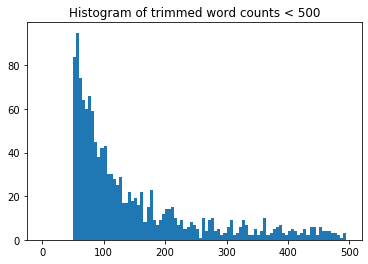

Done!


,word,word_count
0,fast,416
1,dont,1123
2,jonasbrothers,32
3,think,2555
4,shower,205


In [11]:
# set cutoff = 50 since we'r targeting the popular word
positive_word_cloud = generate_word_cloud(data=df, cutoff=50, sentiment=0) # sentiment = 0 for positive
# Look for first 5 rows of the dataframe
positive_word_cloud.head()

Q2: Generate word cloud for negative sentiment.

Computing full term-document matrix (sparse), please wait!


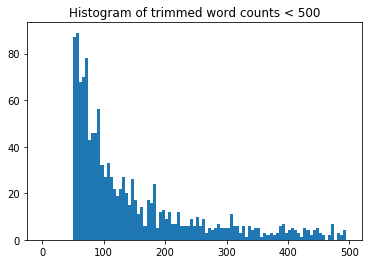

Done!


,word,word_count
0,first,803
1,easier,57
2,l,64622
3,thursday,49
4,cheers,56


In [12]:
# set cutoff = 50 since we'r targeting the popular word
negative_word_cloud = generate_word_cloud(data=df, cutoff=50, sentiment=1) # sentiment = 1 for negative
# Look for first 5 rows of the dataframe
negative_word_cloud.head()

Q3: Split data into 70% for training and 30% for testing.

In [9]:
# Declare the TFIDF vectorizer.
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, max_features=6228, stop_words='english')

# Fit the vectorizer over the dataset
clean_texts = df['clean_tweet']
tf_idf_tweets = vectorizer.fit_transform(clean_texts)

In [10]:
tweet_data = df.values.tolist()

print('Splitting into train-test. Please wait!')

# Get number of 30% training from the total tweet
n_30_percent_testing = int(len(tweet_data)*0.3)

print(f'\033[1m\033[4m30% Testing Data Set: \033[0m')
print(n_30_percent_testing)

y_targets = np.array([y[0] for y in tweet_data])

X_train, X_test, y_train, y_test = train_test_split(tf_idf_tweets,
                                                    y_targets,
                                                    test_size=n_30_percent_testing,
                                                    random_state=42)
print('Done!')

Splitting into train-test. Please wait!
30% Testing Data Set: 
48000
Done!


Q4: Build a classifier that classifies the sentiment of a sentence.

In [11]:
print('Starting a standard Logistic Model training!')
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('Done.')

Starting a standard Logistic Model training!
Done.


Q5: What is the accuracy of your model when applied to testing data?

In [12]:
## Compute results on the train and test set
train_probs = lr.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

# Compute accuracies
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

Train accuracy: 0.7812767857142857
Test accuracy: 0.7554375


In [14]:
# Computes the precision, recall and Fscore of the model for positive and negative tweets
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)

# Get the parts of the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

# Print results
print('Confusion Matrix:')
print(confusion_matrix(y_test, test_results))
print('='*35)
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

Confusion Matrix:
[[17488  6556]
 [ 5183 18773]]
             Class 1   -   Class 0
Precision: [0.77138194 0.74116625]
Recall   : [0.72733322 0.78364502]
F1       : [0.74871026 0.76181394]
Support  : [24044 23956]


Q6: What conclusions can you draw from the model?

#### Examine the results:
1. From **Confusion Matrix**: 
    - **True Positive = 18,773** and **True Negative = 17,488**
    - **False Negative (Type II error) = 5,183** and **False Positive (Type I error) = 6,556** 
2. **Precision** when we predict if this word has either positive or negative sentiment are almost the same (+70%) which mean when we predict 100 times, we will get it correct 70 times.
3. **Recall** for both class 1 (negative) and class 0 (positive) are pretty good which mean we have the useful proportion of both cases about +70% amoung the overall data.
4. **F1** for both class 1 (negative) and class 0 (positive) are pretty good and our data sorce has pretty ok even class distribution for both cases.

Q7: Is it better to have a model per source?

Different data sources have different characteristic and bias. For example, if this model is for **Classification**, different data source might not yield the same accuracy result. Let say, in our assignment, our data source is from **tweet** which can have a lot of **typos** and special meaning text such as **emoji**. The model to train this will be different if the data source came from a **textbook** which has less typos and prone to use more **latin words**. The model which is work very well on the tweet might not work well on the data source from the textbook since the nature of the language are different.